In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
import pickle
from flowpm.fourier_smoothing import fourier_smoothing
from DifferentiableHOS.transforms import starlet2d
import cmasher as cmr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import jax
import jax_cosmo as jc
import jax.numpy as jnp
from scipy.stats import norm
from jax.config import config
config.update("jax_enable_x64", True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
km=pickle.load(open("/global/u1/d/dlan/res_maps_1kmap_231.pkl","rb"))['kmap']

In [3]:
image = tf.cast(km, dtype=tf.float32)
wt = tf.stack(starlet2d(image, 7, padding='SAME'),axis=0)

In [4]:
cmap = cmr.eclipse
TI=['$\\theta=0.584$','$\\theta=1.168$','$\\theta=2.336$','$\\theta= 4.672$', '$\\theta= 9.344$','$\\theta=18.70$','$\\theta=37.38$']
image_paths=[tf.reshape(wt[0], [1024, 1024]),tf.reshape(wt[1], [1024, 1024]),tf.reshape(wt[2], [1024, 1024]),tf.reshape(wt[3], [1024, 1024]),tf.reshape(wt[4], [1024, 1024]),tf.reshape(wt[5], [1024, 1024]),tf.reshape(wt[6], [1024, 1024])]



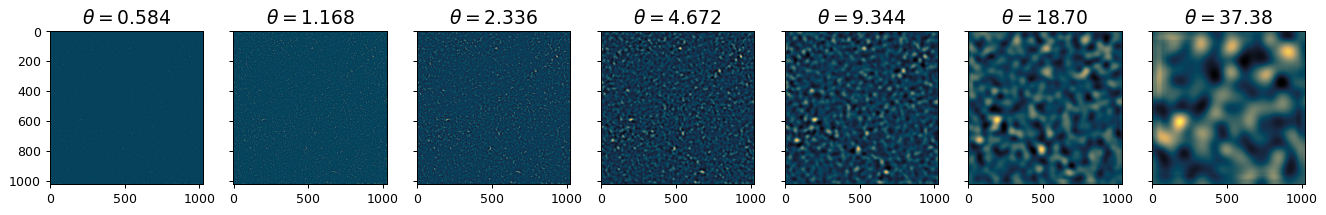

In [5]:
cmap = cmr.eclipse
ticks_size = 18
f, axes = plt.subplots(1, 7, sharey=True, figsize=(18,5), dpi=90)
for imp, ax, ci in zip(image_paths, axes.ravel(),TI):
    ax.imshow(imp, cmap=cmap)
    ax.set_aspect('equal')
    ax.set_title(ci, fontsize=15)
    ax.grid(False)
    divider = make_axes_locatable(ax)

#plt.savefig('../figures/cluster_all_scales.pdf')

In [6]:
l, ps0= DHOS.statistics.power_spectrum(
    km[0],  5, 1024)
l, ps_ms_5_6 = DHOS.statistics.power_spectrum_mulscale(
   km ,  5, 1024, nmin=4, nmax=6)
l, ps_ms_5_6_7 = DHOS.statistics.power_spectrum_mulscale(
   km ,  5, 1024,nmin=4, nmax=7)

In [7]:
l1, ps5= DHOS.statistics.power_spectrum(
   tf.reshape(wt[4], [1024, 1024]),  5, 1024)
l2, ps6= DHOS.statistics.power_spectrum(
    tf.reshape(wt[5], [1024, 1024]),  5, 1024)
l3, ps7= DHOS.statistics.power_spectrum(
    tf.reshape(wt[6], [1024, 1024]),  5, 1024)

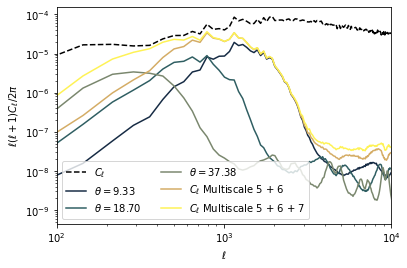

In [8]:
col = cmr.eclipse(np.linspace(0.,1,6))  
loglog(l, l*(l+1)*ps0/(2*np.pi),'--',label='$C_{\ell}$',color=col[0])
loglog(l, l*(l+1)*ps5/(2*np.pi),label='$\\theta=9.33$',color=col[1])
loglog(l, l*(l+1)*ps6/(2*np.pi),label='$\\theta=18.70$',color=col[2])
loglog(l, l*(l+1)*ps7/(2*np.pi),label='$\\theta=37.38$',color=col[3])
loglog(l, l*(l+1)*ps_ms_5_6/(2*np.pi),label='$C_{\ell}$ Multiscale 5 + 6',color=col[4])
loglog(l, l*(l+1)*ps_ms_5_6_7/(2*np.pi),label='$C_{\ell}$ Multiscale 5 + 6 + 7',color=col[5])
xlim(1e2,1e4)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend(ncol=2)
#plt.savefig('../figures/ps_2scales.png', dpi=250)

In [9]:
ratio_5_6_7=ps_ms_5_6_7/ps0

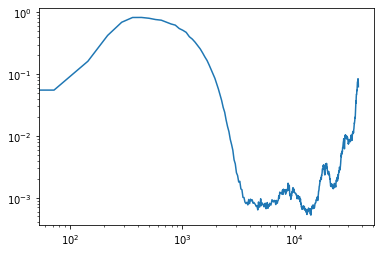

In [10]:
loglog(l,ratio_5_6_7)

In [11]:
ratio_5_6_7=ratio_5_6_7[2:46]
ell=l.numpy()[2:46]

In [12]:

def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return np.mean(np.reshape(a, sh), axis=-1)


In [13]:
ratio_5_6_7=rebin(ratio_5_6_7,11)
ell=rebin(ell,11)

In [14]:
ratio_5_6_7=rebin(ratio_5_6_7,11)
ell=rebin(ell,11)

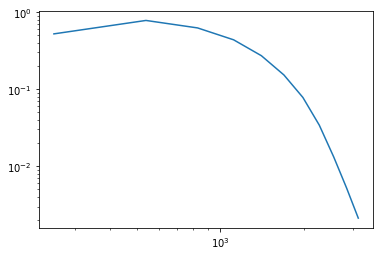

In [15]:
loglog(ell,ratio_5_6_7)

In [16]:
import jax_cosmo.power as power
import jax_cosmo.transfer as tklib

def gaussian_cl_covariance_and_mean(
    cosmo,
    ell,
    probes,
    window=ratio_5_6_7,
    transfer_fn=tklib.Eisenstein_Hu,
    nonlinear_fn=power.halofit,
    f_sky=15_000/41_253,
    sparse=False,
):
    ell = np.atleast_1d(ell)
    n_ell = len(ell)

    # Compute signal vectors
    cl_signal = jc.angular_cl.angular_cl(
        cosmo, ell, probes, transfer_fn=transfer_fn, nonlinear_fn=nonlinear_fn
    )*window
    cl_noise = jc.angular_cl.noise_cl(ell, probes)*window
    cov_mat =  jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky, sparse)

    return cl_signal.flatten(), cov_mat


### Let's plot the Theoretical Fisher matrix comparable to our analysis 

In [17]:
cosmo = jc.Planck15()

In [18]:
params = np.array([cosmo.Omega_c, cosmo.sigma8, cosmo.Omega_b, cosmo.n_s, cosmo.h, cosmo.w0, 0.0]) 
params_names = ["$\Omega_c$",  "$\sigma_8$", "$\Omega_b$",  "$n_s$", "$h$", "$w0$", "$A_{IA}$"]


In [19]:
cosmo=jc.Planck15()
z = linspace(0,2,1024)
nz=[jc.redshift.kde_nz(z, norm.pdf(z, loc=0.91, scale=0.01), bw=0.01,
                                  gals_per_arcmin2=20., zmax=1.)]

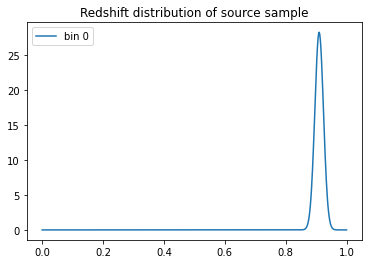

In [20]:
zs = np.linspace(0, 1, 512)
for i in range(1):
  plot(zs, nz[i](zs), label='bin %d'%i)
legend()
title('Redshift distribution of source sample');

In [21]:
probes=[ jc.probes.WeakLensing(nz, sigma_e=0.26)]
mu, cov= gaussian_cl_covariance_and_mean(cosmo, ell, probes)

In [22]:
# We define a parameter dependent function that computes the mean
@jax.jit
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1],Omega_b=p[2],n_s=p[3],h=p[4],w0=p[5])
  # Compute signal vector
  probes = [ jc.probes.WeakLensing(nz, sigma_e=0.26, ia_bias=[jc.bias.constant_linear_bias(p[6])])]
  m = jc.angular_cl.angular_cl(cosmo,ell, probes,)*ratio_5_6_7
  return m.flatten() # We want it in 1d to operate against the covariance matrix

In [23]:
# We compute it's jacobian with JAX, and we JIT it for efficiency
jac_mean = jax.jit(jax.jacfwd(mean_fn))


In [24]:
dmu = jac_mean(params)


In [25]:
F = dmu.T @ np.linalg.inv(cov) @ dmu 

In [26]:
print("Fisher matrix conditionning before priors", cond(F))
# Adding priors
F  = F + jnp.diag(1./jnp.array([0.2, 0.14, 0.006, 0.08, 0.063, 0.8, 3.]))**2
print("Fisher matrix conditionning after priors", cond(F))
P = jnp.linalg.pinv(F)

Fisher matrix conditionning before priors 6643783326206.487
Fisher matrix conditionning after priors 124074181.79910956


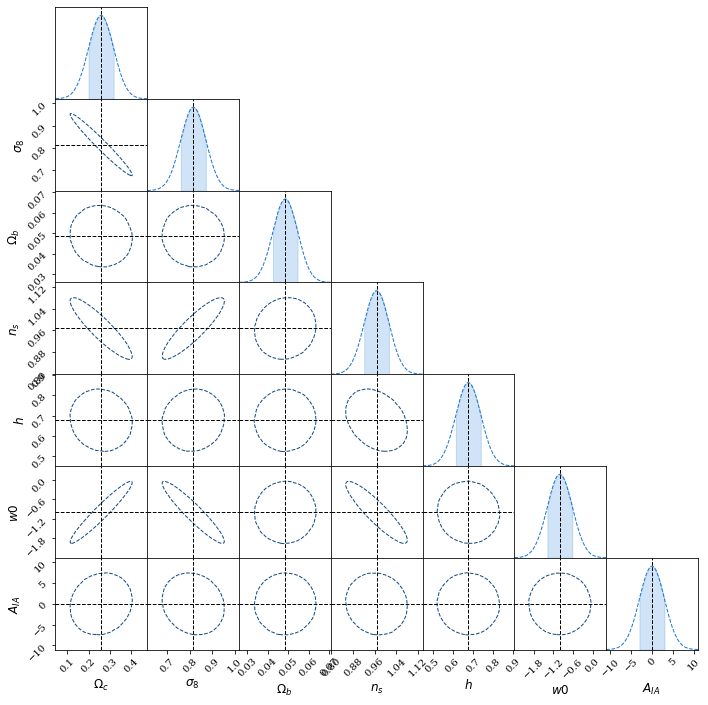

In [27]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_covariance(params, P, 
                 parameters=params_names)

c.configure(usetex=False, sigmas=[0,2], shade=[False, False],linestyles=["--", "-"],)
fig = c.plotter.plot(truth=params)

In [28]:
jc.background.f_de??

Signature: jc.background.f_de(cosmo, a)
Docstring:
Evolution parameter for the Dark Energy density.

Parameters
----------
a : array_like
    Scale factor

Returns
-------
f : ndarray, or float if input scalar
    The evolution parameter of the Dark Energy density as a function
    of scale factor

Notes
-----

For a given parametrisation of the Dark Energy equation of state,
the scaling of the Dark Energy density with time can be written as:

.. math::

    \rho_{de}(a) \propto a^{f(a)}

(see :cite:`2005:Percival`) where :math:`f(a)` is computed as
:math:`f(a) = \frac{-3}{\ln(a)} \int_0^{\ln(a)} [1 + w(a^\prime)]
d \ln(a^\prime)`. In the case of Linder's parametrisation for the
dark energy in Eq. :eq:`linderParam` :math:`f(a)` becomes:

.. math::

    f(a) = -3(1 + w_0) + 3 w \left[ \frac{a - 1}{ \ln(a) } - 1 \right]
    
Source:   
def f_de(cosmo, a):
    r"""Evolution parameter for the Dark Energy density.

    Parameters
    ----------
    a : array_like
        Scale factor

    R